# Single Night LST-Binned Calibration Notebook

**by Tyler Cox**, last updated on Sept 8th, 2025

This notebook performs LST-binned calibration (or LST-cal) on whole-JD, single-baseline, all polarization files. Most parameters are controlled by a toml config file, [such as this one](https://github.com/HERA-Team/hera_pipelines/blob/main/pipelines/h6c/idr3/v1/lstbin/single_bl_lst_stack_config.toml). In addition to single-baseline files, this notebook also requires UVFlag-compatible `where_inpainted` files which tell us where inpainting was previously done.

To keep the total memory footprint of the notebook reasonable, the full list of baselines are first downselected to a subset of the `Nbls` redundant baseline types that have the largest number of `nsamples`, and then compute the redundant-calibration degenerate parameters (namely, the per-frequency/time amplitude, tip-tilt, and cross-polarized phase degeneracies) that bring a single night into better alignment with the LST-average. The calibration parameters are then smoothed in time and frequency with DPSS basis functions given a user specified time and frequency smoothing scale.

Here's a set of links to skip to particular figures and tables:

# [• Figure 1: Amplitude Parameters Before/After Smoothing](#Figure-1:-Amplitude-Parameters-Before/After-Smoothing)
# [• Figure 2: Tip/Tilt Parameters Before/After Smoothing](#Figure-2:-Tip/Tilt-Parameters-Before/After-Smoothing)
# [• Figure 3: Cross-Polarized Phase Before/After Smoothing](#Figure-3:-Cross-Polarized-Phase-Before/After-Smoothing)
# [• Figure 4: Visibility/LST-Averaged Variance Across Baseline Before/After LST-Cal](#Figure-4:-Visibility/LST-Averaged-Variance-Across-Baseline-Before/After-LST-Cal)

In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu') # Force jax to use CPU if GPU available

import re
import os
import yaml
import time
import glob
import toml
import numpy as np
import pylab as plt
from copy import deepcopy
from functools import reduce
from tqdm.notebook import tqdm

from pyuvdata import UVData
from hera_cal.lst_stack import LSTConfig
from hera_cal import lst_stack, io, flag_utils, abscal, datacontainer, redcal, utils, smooth_cal, red_groups
from hera_qm.time_series_metrics import true_stretches
from hera_filters.dspec import fourier_filter, dpss_operator
from hera_cal.lst_stack.calibration import _expand_degeneracies_to_ant_gains
from hera_cal.lst_stack.config import LSTBinConfiguratorSingleBaseline, make_lst_grid
from hera_cal.lst_stack.binning import SingleBaselineStacker, _get_freqs_chans, adjust_lst_bin_edges, _allocate_dfn, get_lst_bins

from hera_qm.metrics_io import read_a_priori_ant_flags

import warnings
warnings.filterwarnings("ignore", module="hera_cal")
%load_ext line_profiler

In [2]:
toml_file = os.environ.get(
    'TOML_FILE', '/lustre/aoc/projects/hera/h6c-analysis/IDR3/src/hera_pipelines/pipelines/h6c/idr3/v1/lstbin/single_bl_lst_stack.toml'
)
print(f'toml_file = "{toml_file}"')

baseline_string = os.environ.get('BASELINE_STRING', "0_0")
print(f'baseline_string = "{baseline_string}"')

toml_file = "/lustre/aoc/projects/hera/h6c-analysis/IDR3/src/hera_pipelines/pipelines/h6c/idr3/v1/lstbin/single_bl_lst_stack.toml"
baseline_string = "0_0"


In [3]:
# get options from toml file, print them out, and update globals
toml_options = toml.load(toml_file)

print(f"Now setting the following global variables from {toml_file}:\n")

globals().update({'lst_branch_cut': toml_options['FILE_CFG']['lst_branch_cut']})
print(f"lst_branch_cut = {lst_branch_cut}")

globals().update({'where_inpainted_file_rules': toml_options['FILE_CFG']['where_inpainted_file_rules']})
print(f"where_inpainted_file_rules = {where_inpainted_file_rules}")

# this is used for an initial stacking of a handful of baselines, which are then used for LSTCal
toml_options['LST_STACK_OPTS']['FNAME_FORMAT'] = toml_options['LST_STACK_OPTS']['FNAME_FORMAT'].replace('.sum.uvh5', '.preliminary.sum.uvh5')

for key, val in toml_options['LSTCAL_OPTS'].items():
    if isinstance(val, str):
        print(f'{key} = "{val}"')
    else:
        print(f'{key} = {val}')
globals().update(toml_options['LSTCAL_OPTS'])
        
for key, val in toml_options['LST_STACK_OPTS'].items():
    if isinstance(val, str):
        print(f'{key} = "{val}"')
    else:
        print(f'{key} = {val}')
globals().update(toml_options['LST_STACK_OPTS'])

Now setting the following global variables from /lustre/aoc/projects/hera/h6c-analysis/IDR3/src/hera_pipelines/pipelines/h6c/idr3/v1/lstbin/single_bl_lst_stack.toml:

lst_branch_cut = 5.2
where_inpainted_file_rules = [['.inpainted.uvh5', '.where_inpainted.h5']]
NBLS_FOR_LSTCAL = 30
RUN_AMPLITUDE_CAL = True
RUN_TIP_TILT_PHASE_CAL = True
RUN_CROSS_POL_PHASE_CAL = True
FREQ_SMOOTHING_SCALE = 30.0
TIME_SMOOTHING_SCALE = 2500
BLACKLIST_TIMESCALE_FACTOR = 10
BLACKLIST_RELATIVE_ERROR_THRESH = 1
WHERE_INPAINTED_WGTS = 0.0001
LSTCAL_FNAME_FORMAT = "single_bl_reinpaint_1000ns/zen.{night}.lstcal.hdf5"
OUTDIR = "/lustre/aoc/projects/hera/h6c-analysis/IDR3/lststack-outputs"
FNAME_FORMAT = "single_bl_reinpaint_1000ns/zen.LST.baseline.{bl_str}.preliminary.sum.uvh5"
FM_LOW_FREQ = 87.5
FM_HIGH_FREQ = 108.0
EIGENVAL_CUTOFF = 1e-12
INPAINT_DELAY = 1000
AUTO_INPAINT_DELAY = 100
INPAINT_WIDTH_FACTOR = 0.5
INPAINT_ZERO_DIST_WEIGHT = 0.01
MIN_NIGHTS_PER_BIN = 3
MAX_CHANNEL_NIGHTLY_FLAG_FRAC = 0.25
MOD_Z_TO_R

In [4]:
# Baseline configurator
configurator = lst_stack.config.LSTBinConfiguratorSingleBaseline.from_toml(toml_file)
auto_baseline_string = [s for s in configurator.bl_to_file_map if (p := s.split('_'))[0] == p[1]][0]

# Get metadata for LST-stacking
hd = io.HERAData(
    configurator.bl_to_file_map[baseline_string][-1]
)
df = np.median(np.diff(hd.freqs))
dlst = np.median(np.diff(hd.lsts))
lst_grid = lst_stack.config.make_lst_grid(dlst, begin_lst=0, lst_width=(2 * np.pi)) # _fix_dlst function making the grid the wrong size
lst_bin_edges =  np.concatenate([lst_grid - dlst / 2, (lst_grid[-1] + dlst / 2)[None]])

# Julian dates for LST-calibration
jds = [int(night) for night in configurator.nights]
filepath = toml_options['FILE_CFG']['datafiles']['datadir']
aposteriori_yamls = {jd: filepath + f'/{jd}/{jd}_aposteriori_flags.yaml' for jd in jds}

# 1. Load Single Night Data and Rephase to Correct LST-bins

In [5]:
all_bl_strings = sorted(list(configurator.bl_to_file_map.keys()))

bl_string_to_jd_map = {
    bl_string: night
    for night, bl_string in zip(sorted(configurator.nights), all_bl_strings)
}

# Get baseline keys from the files that have been previously saved by the stacking notebook
single_bl_files = glob.glob(
    os.path.join(OUTDIR, FNAME_FORMAT.format(bl_str="*"))
)

pattern = '^' + re.escape(os.path.join(OUTDIR, FNAME_FORMAT)).replace(r'\{bl_str\}', r'(?P<a>\d+)_(?P<b>\d+)') + '$'
rx = re.compile(pattern)

baselines = []
baseline_strings = []
for file in single_bl_files:
    match = rx.match(file)
    i, j = map(int, match.groups())
    baselines.append((i, j))
    baseline_strings.append("{}_{}".format(i, j))

In [6]:
# Get the JD for this particular file
RUN_CALIBRATION = baseline_string in bl_string_to_jd_map

if RUN_CALIBRATION:
    jd_here = bl_string_to_jd_map[baseline_string]
    
    # Now load good baselines for a single day
    single_day_config = deepcopy(configurator)
    single_day_config.nights = [str(jd_here)]
    single_day_config.bl_to_file_map = single_day_config.build_bl_to_file_map()
    
    # Set up dictionaries to store 
    data_for_cal = {}
    wgts = {}
    model = {}
    where_inpainted = {}
    all_flagged = {}
    
    if RUN_CROSS_POL_PHASE_CAL:
        cross_pol_model = {}
        cross_pol_data = {}
    
    # Loop through baseline strings
    for bl_string in tqdm(baseline_strings):
        crosses = SingleBaselineStacker.from_configurator(
            single_day_config,
            bl_string,
            lst_bin_edges,
            lst_branch_cut=lst_branch_cut, 
            where_inpainted_file_rules=where_inpainted_file_rules
        )
    
        # Get antennas that make up the baseline
        ai, aj = list(map(int, bl_string.split('_')))
    
        # Load the corresponding LST-binned baseline
        bl_to_load = os.path.join(OUTDIR, FNAME_FORMAT.format(bl_str=bl_string))
        
        polarizations = crosses.hd.pols if RUN_CROSS_POL_PHASE_CAL else crosses.hd.pols[:2]
        hd = io.HERAData(bl_to_load)
        single_bl_stacked_data, lst_avg_flags, _ = hd.read(polarizations=polarizations)
    
        # Match lst-averaged to data and handle precision loss from converting to times to LSTs
        lst_grid = hd.lsts.copy()
        lst_grid[lst_grid[0] > lst_grid] += 2 * np.pi
        lst_grid_rounding_factor = np.abs(np.floor(np.log10(dlst) - 2)).astype(int)
        indices = np.searchsorted(
            np.round(lst_grid, lst_grid_rounding_factor), 
            np.round(crosses.bin_lst, lst_grid_rounding_factor)
        )
    
        
        for pi, pol in enumerate(polarizations):
            # Set the weights
            nsamples = np.concatenate([_nsamples[..., pi] for _nsamples in crosses.nsamples], axis=0)
            flags = np.concatenate([_flags[..., pi] for _flags in crosses.flags], axis=0)
            model_flags = np.concatenate([
                np.repeat(lst_avg_flags[(ai, aj, pol)][[idx]], len(tinb), axis=0)
                for idx, tinb in zip(indices, crosses.times_in_bins)
            ], axis=0)
            flags |= model_flags
            
            wgts[(ai, aj, pol)] = nsamples * (~flags).astype(float)
            
            if pol in flags:
                all_flagged[pol] &= flags
            else:
                all_flagged[pol] = flags
    
            if pol in where_inpainted:
                where_inpainted[pol] &= np.concatenate([winp[..., pi] for winp in crosses.where_inpainted], axis=0)
            else:
                where_inpainted[pol] = np.concatenate([winp[..., pi] for winp in crosses.where_inpainted], axis=0)
            
            if pol[0] == pol[1]:
                data_for_cal[(ai, aj, pol)] = np.concatenate([_data[..., pi] for _data in crosses.data], axis=0)
                model[(ai, aj, pol)] = np.concatenate([
                    single_bl_stacked_data[(ai, aj, pol)][[idx]] * np.ones((len(tinb), 1))
                    for idx, tinb in zip(indices, crosses.times_in_bins)
                ], axis=0)
            else:
                cross_pol_data[(ai, aj, pol)] = np.concatenate([_data[..., pi] for _data in crosses.data], axis=0)
                cross_pol_model[(ai, aj, pol)] = np.concatenate([
                    single_bl_stacked_data[(ai, aj, pol)][[idx]] * np.ones((len(tinb), 1))
                    for idx, tinb in zip(indices, crosses.times_in_bins)
                ], axis=0)
    
            
    
    # Get the frequencies and times of the data
    freqs = crosses.hd.freqs
    times = np.concatenate(crosses.times_in_bins)

    # Get the original time grid
    single_jd_hd = io.HERAData(single_day_config.bl_to_file_map[bl_string])
    single_jd_times = single_jd_hd.times

  0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
if RUN_CALIBRATION:
    autos = SingleBaselineStacker.from_configurator(
        configurator,
        auto_baseline_string,
        lst_bin_edges,
        lst_branch_cut=lst_branch_cut, 
        where_inpainted_file_rules=where_inpainted_file_rules
    )
    lst_avg_autos, _, _ = autos.average_over_nights()
    
    auto_model = {}
    for pi, pol in enumerate(polarizations):
        auto_model[(0, 0, pol)] = np.concatenate([
            lst_avg_autos[..., pi][[idx]] * np.ones((len(tinb), 1))
            for idx, tinb in zip(indices, crosses.times_in_bins)
        ], axis=0)

# 2. LST-Binned Calibration

In [8]:
def complex_phase_abscal(data, model, reds, data_bls, model_bls, transformed_antpos=None, newton_maxiter=50):
    """
    Stripped down version of hera_cal.abscal.complex_phase_abscal that assumes the tip-tilt solution is close to zero. 
    Calculates gains that would absolute calibrate the phase of already redundantly-calibrated data. 
    Only operates one polarization at a time.

    Parameters:
    ----------
    data : DataContainer or RedDataContainer
        Dictionary-like container mapping baselines to data visibilities to abscal
    model : DataContainer or RedDataContainer
        Dictionary-like container mapping baselines to model visibilities
    reds : list of lists
        List of lists of redundant baselines tuples like (0, 1, 'ee'). Ignored if transformed_antpos is not None.
    data_bls : list of tuples
        List of baseline tuples in data to use.
    model_bls : list of tuples
        List of baseline tuples in model to use. Must correspond the same physical separations as data_bls.
    transformed_antpos : dict
        Dictionary of abstracted antenna positions that you'd normally get from redcal.reds_to_antpos().
        If None, will be inferred from reds.

    Returns:
    -------
    meta : dictionary
        Contains keys for
            'Lambda_sol' : phase gradient solutions,
            'Z_sol' : value of the objective function at the solution,
            'newton_iterations' : number of iterations completed by the Newton's method solver
    delta_gains : dictionary
        Dictionary mapping antenna keys like (0, 'Jee') to gains of the same shape of the data
    """
    # Check that baselines selected are for the same polarization
    pols = list(set([bl[2] for bls in (data_bls, model_bls) for bl in bls]))
    assert len(pols) == 1, 'complex_phase_abscal() can only solve for one polarization at a time.'

    # Get transformed antenna positions and baselines
    if transformed_antpos is None:
        transformed_antpos = redcal.reds_to_antpos(reds)
    abscal._put_transformed_array_on_integer_grid(transformed_antpos)
    transformed_b_vecs = np.rint([transformed_antpos[jj] - transformed_antpos[ii] for (ii, jj, pol) in data_bls]).astype(int)

    # Get number of baselines and times/freqs
    Ngroups = len(data_bls)
    Ntimes, Nfreqs = data[data_bls[0]].shape

    # Build up array of Fourier coefficients of the objective function
    Z_coefficients = np.zeros((Ntimes, Nfreqs, Ngroups), dtype=complex)
    for nn in range(Ngroups):

        Vhat_n = data[data_bls[nn]]
        Vbar_n = model[model_bls[nn]]
        Z_coefficients[:, :, nn] = Vhat_n * np.conj(Vbar_n)

    # Get solution for degenerate phase gradient vectors
    Ntimes, Nfreqs, Ngroups = Z_coefficients.shape
    Ndims = transformed_b_vecs.shape[1]

    Lambda_sol = np.zeros((Ntimes, Nfreqs, Ndims), dtype=float)

    for i_t in range(Ntimes):
        for i_f in range(Nfreqs):
            Z_coeffs_t_f = Z_coefficients[i_t, i_f]
            Lambda_t_f, niter_t_f = abscal._newton_solve(np.zeros(Ndims), transformed_b_vecs, Z_coeffs_t_f, 1e-8, maxiter=newton_maxiter)
            Lambda_sol[i_t, i_f] = -Lambda_t_f
        
    # turn solution into per-antenna gains
    meta = {
        'Lambda_sol': Lambda_sol, 
        'transformed_antpos': transformed_antpos
    }
    return meta

In [9]:
%%time
if RUN_CALIBRATION:
    # Amplitude Calibration
    if RUN_AMPLITUDE_CAL:
        amplitude_solutions = abscal.abs_amp_lincal(
            model=model,
            data=data_for_cal,
            wgts=wgts,
            verbose=False,
        )
    else:
        data_shape = data_for_cal[list(data_for_cal.keys())[0]].shape
        amplitude_solutions['ee'] = np.ones(data_shape)
        amplitude_solutions['nn'] = np.ones(data_shape)
    
    # Tip-tilt Phase Calibration
    if RUN_TIP_TILT_PHASE_CAL:
        # Get the redundancies
        all_reds = red_groups.RedundantGroups.from_antpos(
            antpos=hd.antpos, 
            pols=('nn', 'ee'), 
            include_autos=False
        )
    
        # Fit the tip-tilt for both pols
        phase_solutions = {}
        for pol in ['ee', 'nn']:
            phase_fit = complex_phase_abscal(
                {k: data_for_cal[k][:] for k in data_for_cal if k[-1] == pol}, 
                {k: model[k][:] for k in model if k[-1] == pol}, 
                all_reds, 
                [k for k in data_for_cal if k[-1] == pol], 
                [k for k in model if k[-1] == pol], 
            )
            phase_solutions[pol] = phase_fit['Lambda_sol']
    
        transformed_antpos = phase_fit['transformed_antpos']   
    else:
        data_shape = data_for_cal[list(data_for_cal.keys())[0]].shape
        phase_solutions = {}
        for pol in ['ee', 'nn']:
            phase_fit = np.zeros(data_shape + (2,))
            phase_solutions[pol] = phase_fit
    
        transformed_antpos = hd.antpos
        
    if RUN_CROSS_POL_PHASE_CAL:
        cross_pol_phase = abscal.cross_pol_phase_cal(
            model=cross_pol_model,
            data=cross_pol_data,
            model_bls=list(cross_pol_model.keys()),
            data_bls=list(cross_pol_data.keys()),
            wgts=wgts,
        )
    else:
        data_shape = data_for_cal[list(data_for_cal.keys())[0]].shape
        cross_pol_phase = np.zeros(data_shape)

CPU times: user 24min 54s, sys: 1min 37s, total: 26min 32s
Wall time: 15min 2s


In [10]:
if RUN_CALIBRATION:
    # Check blacklisting in amplitude calibration (harder to do in phase)
    blacklist_wgts = {}
    
    avg_wgts = {
        pol: np.mean([wgts[key] for key in wgts if pol in key], axis=0)
        for pol in polarizations
    }
    
    for pol in ['ee', 'nn']:
        if RUN_AMPLITUDE_CAL:
            gains = np.where(
                np.isfinite(amplitude_solutions[f"A_J{pol}"]), 
                amplitude_solutions[f"A_J{pol}"], 
                1.0
            )
            wgts_here = np.where(np.isfinite(amplitude_solutions[f"A_J{pol}"]), avg_wgts[pol], 0.0)
            wgts_here = np.where(where_inpainted[pol], WHERE_INPAINTED_WGTS, wgts_here)
            smoothed_amp, _ = smooth_cal.time_freq_2D_filter(
                gains=gains.astype(complex),
                wgts=wgts_here,
                freqs=freqs,
                times=times,
                freq_scale=FREQ_SMOOTHING_SCALE,
                time_scale=TIME_SMOOTHING_SCALE * BLACKLIST_TIMESCALE_FACTOR,
                eigenval_cutoff=EIGENVAL_CUTOFF,
                method='DPSS', 
                fit_method='lu_solve', 
                fix_phase_flips=False, 
                flag_phase_flip_ints=False,
                skip_flagged_edges=True, 
                freq_cuts=[(FM_LOW_FREQ + FM_HIGH_FREQ) * .5e6],
            ) 
            blacklist_wgts[pol] = np.where(
                (np.abs(gains - smoothed_amp) / np.abs(smoothed_amp)) > BLACKLIST_RELATIVE_ERROR_THRESH,
                0.0,
                1.0
            )
        else:
            blacklist_wgts[pol] = np.ones_like(amplitude_solutions[f"A_J{pol}"])

invalid value encountered in divide
invalid value encountered in divide


In [26]:
if RUN_CALIBRATION:
    smoothed_tip_tilt = {}
    smoothed_amplitude = {}
    
    for pol in ['ee', 'nn']:
        if RUN_AMPLITUDE_CAL:
            gains = np.where(
                np.isfinite(amplitude_solutions[f"A_J{pol}"]), 
                amplitude_solutions[f"A_J{pol}"], 
                1.0
            )
            wgts_here = np.where(np.isfinite(amplitude_solutions[f"A_J{pol}"]), avg_wgts[pol], 0.0)
            wgts_here = np.where(where_inpainted[pol], WHERE_INPAINTED_WGTS, wgts_here)
            wgts_here *= blacklist_wgts[pol]
            smoothed_amp, _ = smooth_cal.time_freq_2D_filter(
                gains=gains.astype(complex),
                wgts=wgts_here,
                freqs=freqs,
                times=times,
                freq_scale=FREQ_SMOOTHING_SCALE,
                time_scale=TIME_SMOOTHING_SCALE,
                eigenval_cutoff=EIGENVAL_CUTOFF,
                method='DPSS', 
                fit_method='lu_solve', 
                fix_phase_flips=False, 
                flag_phase_flip_ints=False,
                skip_flagged_edges=True, 
                freq_cuts=[(FM_LOW_FREQ + FM_HIGH_FREQ) * .5e6],
            ) 
            smoothed_amplitude[pol] = np.where(
                all_flagged[pol], 1.0, smoothed_amp.real
            )
        else:
            smoothed_amplitude[pol] = np.ones_like(amplitude_solutions[pol])
            
        if RUN_TIP_TILT_PHASE_CAL:
            smoothed_solutions = []
            for i in range(2):
                tip_tilt = phase_solutions[pol][..., i].astype(complex)
                gains = np.where(np.isfinite(tip_tilt), tip_tilt, 0.0)
                wgts_here = np.where(np.isfinite(tip_tilt), avg_wgts[pol], 0.0)
                wgts_here = np.where(where_inpainted[pol], WHERE_INPAINTED_WGTS, wgts_here)
                wgts_here *= blacklist_wgts[pol]
                
                tip_tilt_smoothed, _ = smooth_cal.time_freq_2D_filter(
                    gains=gains,
                    wgts=wgts_here,
                    freqs=freqs,
                    times=times,
                    freq_scale=FREQ_SMOOTHING_SCALE,
                    time_scale=TIME_SMOOTHING_SCALE,
                    eigenval_cutoff=EIGENVAL_CUTOFF,
                    method='DPSS', 
                    fit_method='lu_solve', 
                    fix_phase_flips=False, 
                    flag_phase_flip_ints=False,
                    skip_flagged_edges=True, 
                    freq_cuts=[(FM_LOW_FREQ + FM_HIGH_FREQ) * .5e6],
                ) 
                smoothed_solutions.append(tip_tilt_smoothed.real)
            
            smoothed_tip_tilt[pol] = np.where(
                all_flagged[pol][..., None], 0.0, np.transpose(smoothed_solutions, (1, 2, 0))
            )
        else:
            smoothed_tip_tilt[pol] = np.zeros(wgts[(0, 1, pol)].shape + (2,))
    
    if RUN_CROSS_POL_PHASE_CAL:
        gains = np.where(np.isfinite(cross_pol_phase), cross_pol_phase, 0.0)
        wgts_here = np.where(np.isfinite(cross_pol_phase), avg_wgts['en'] + avg_wgts['ne'], 0.0)
        wgts_here = np.where(where_inpainted[pol], WHERE_INPAINTED_WGTS, wgts_here)
        wgts_here *= blacklist_wgts[pol]
        
        cross_pol_smoothed, _ = smooth_cal.time_freq_2D_filter(
            gains=gains.astype(complex),
            wgts=wgts_here,
            freqs=freqs,
            times=times,
            freq_scale=FREQ_SMOOTHING_SCALE,
            time_scale=TIME_SMOOTHING_SCALE,
            eigenval_cutoff=EIGENVAL_CUTOFF,
            method='DPSS', 
            fit_method='lu_solve', 
            fix_phase_flips=False, 
            flag_phase_flip_ints=False,
            skip_flagged_edges=True, 
            freq_cuts=[(FM_LOW_FREQ + FM_HIGH_FREQ) * .5e6],
        ) 
        cross_pol_smoothed = np.where(
            all_flagged["nn"] | all_flagged["ee"],
            0.0,
            cross_pol_smoothed
        )

# Figure 1: Amplitude Parameters Before/After Smoothing

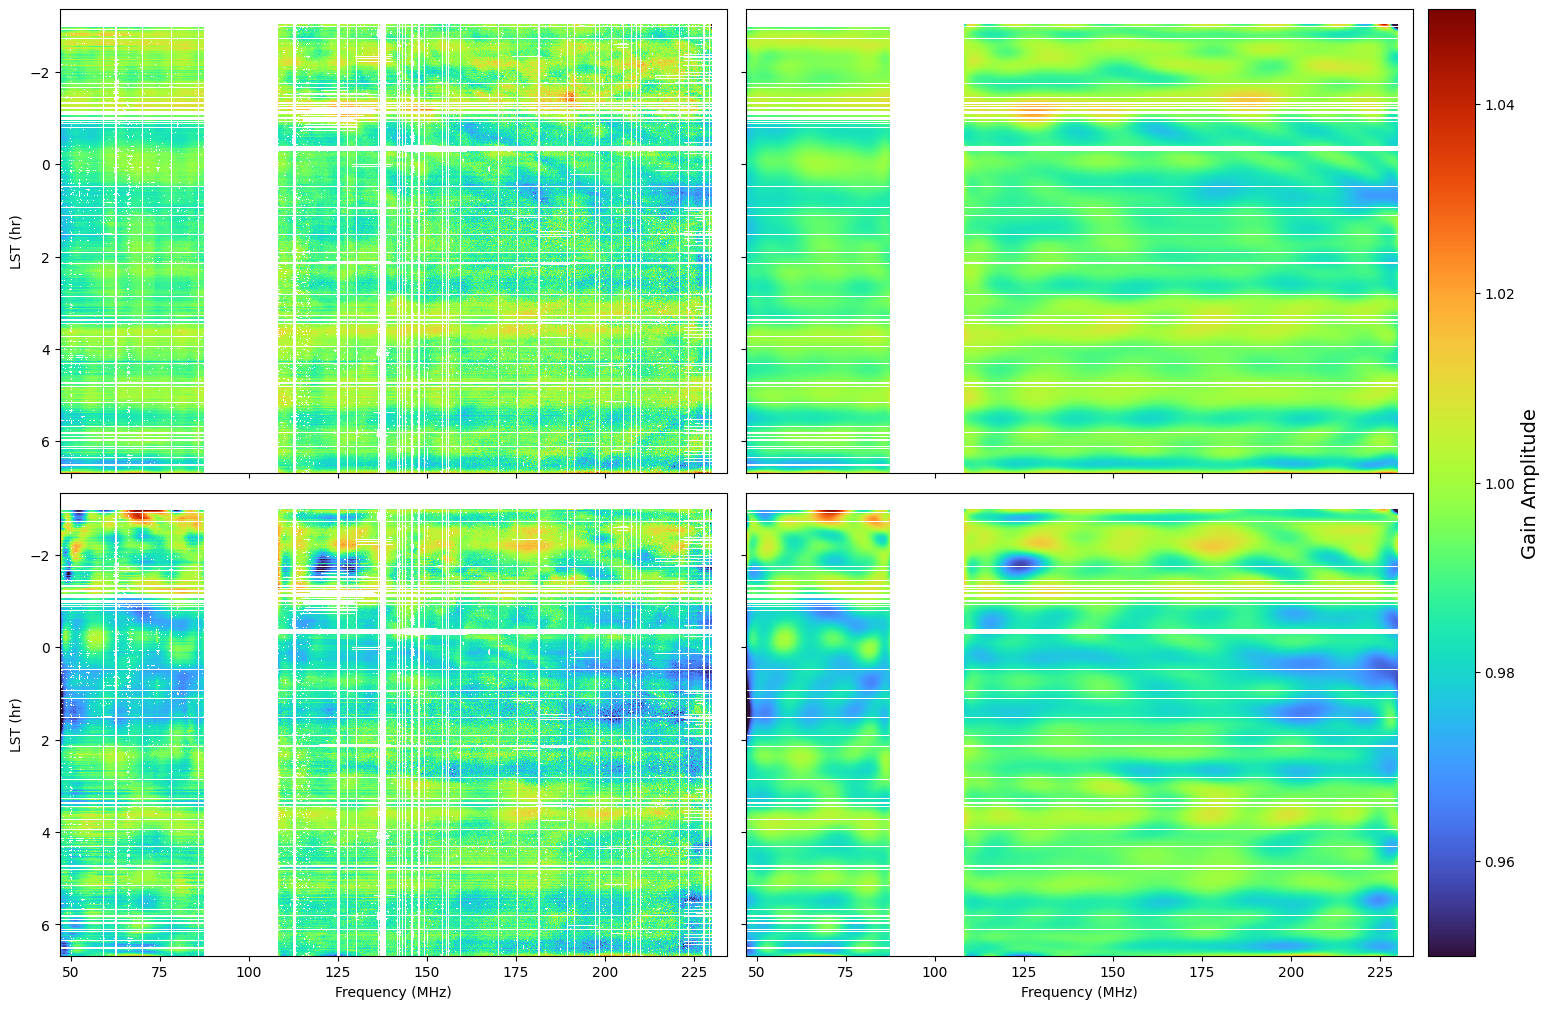

In [27]:
# Get the local times for plotting
if RUN_AMPLITUDE_CAL and RUN_CALIBRATION:
    ai, aj = list(map(int, baseline_strings[0].split("_")))
    lsts = utils.JD2LST(times) * 12 / np.pi
    wrap_point = (lsts[0] + lsts[-1]) / 2
    lsts[wrap_point < lsts] -= 24
    extent = [freqs.min() / 1e6, freqs.max() / 1e6, lsts.max(), lsts.min()]
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
    for pi, pol in enumerate(['ee', 'nn']):
        axs[pi, 0].imshow(
            np.where(
                where_inpainted[pol] | (all_flagged[pol]), 
                np.nan, 
                np.abs(amplitude_solutions[f'A_J{pol}'])
            ), 
            aspect='auto', 
            interpolation='None', 
            vmin=0.95, 
            vmax=1.05, 
            extent=extent, 
            cmap='turbo'
        )
        im = axs[pi, 1].imshow(
            np.where(all_flagged[pol], np.nan, np.abs(smoothed_amplitude[pol])),
            aspect='auto', 
            interpolation='None', 
            vmin=0.95, 
            vmax=1.05, 
            extent=extent, 
            cmap='turbo'
        )
        
    plt.tight_layout()
    axs[1, 0].set_xlabel("Frequency (MHz)")
    axs[1, 1].set_xlabel("Frequency (MHz)")
    axs[0, 0].set_ylabel("LST (hr)")
    axs[1, 0].set_ylabel("LST (hr)")
    cbar = plt.colorbar(im, ax=axs, fraction=0.05, pad=0.01)
    cbar.set_label("Gain Amplitude", fontsize=14)

# Figure 2: Tip/Tilt Parameters Before/After Smoothing

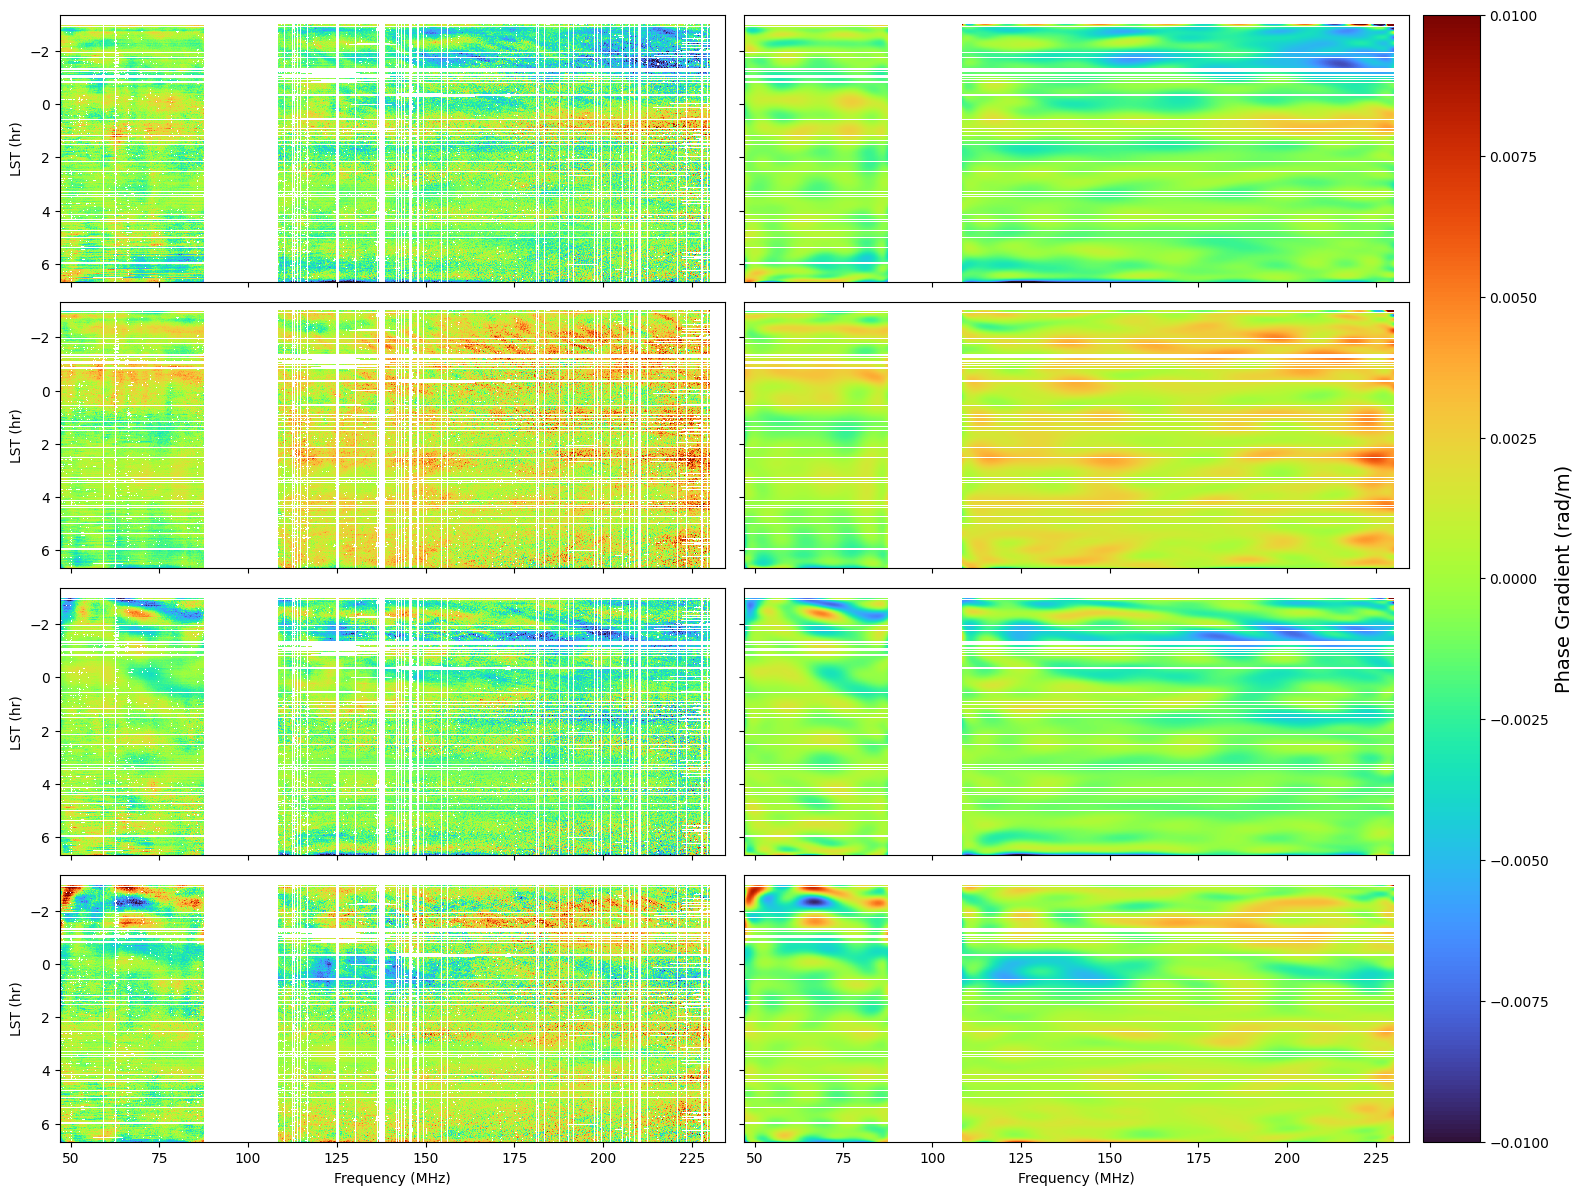

In [28]:
if RUN_TIP_TILT_PHASE_CAL and RUN_CALIBRATION:
    fig, axs = plt.subplots(4, 2, figsize=(15, 12), sharex=True, sharey=True)
    ci = 0
    for pi, pol in enumerate(['ee', 'nn']):
        for ni in range(2):
            axs[ci, 0].imshow(
                np.where(
                    where_inpainted[pol] | (all_flagged[pol]),
                    np.nan,
                    phase_solutions[pol][..., ni],
                ),
                aspect='auto', 
                interpolation='None', 
                vmin=-0.01, 
                vmax=0.01, 
                extent=extent, 
                cmap='turbo'
            )
            tip_tilt = smoothed_tip_tilt[pol][..., ni]
            im = axs[ci, 1].imshow( 
                np.where(all_flagged[pol], np.nan, tip_tilt),
                aspect='auto', 
                interpolation='None', 
                vmin=-0.01, 
                vmax=0.01, 
                extent=extent, 
                cmap='turbo'
            )

            # Labeling
            axs[ci, 0].set_ylabel(r"LST (hr)")
            
            ci += 1
        
        axs[3, 0].set_xlabel(r"Frequency (MHz)")
        axs[3, 1].set_xlabel(r"Frequency (MHz)")
            
    plt.tight_layout()
    cbar = plt.colorbar(im, ax=axs, fraction=0.04, pad=0.01)
    cbar.set_label("Phase Gradient (rad/m)", fontsize=14)

# Figure 3: Cross-Polarized Phase Before/After Smoothing

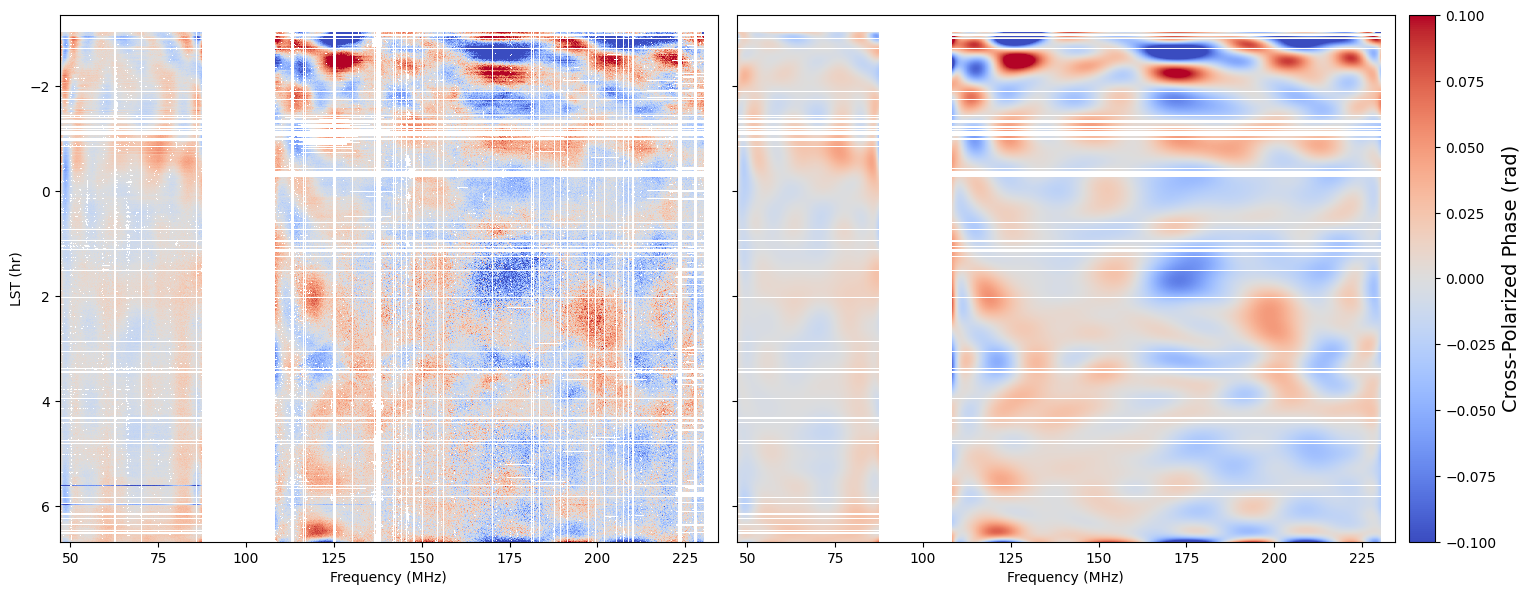

In [29]:
if RUN_CROSS_POL_PHASE_CAL and RUN_CALIBRATION:
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
    pol = 'ne'
    axs[0].imshow(
        np.where(
            where_inpainted[pol] | (all_flagged[pol]),
            np.nan,
            cross_pol_phase,
        ),
        aspect='auto', 
        interpolation='None', 
        vmin=-0.1, 
        vmax=0.1, 
        extent=extent, 
        cmap='coolwarm'
    )
    im = axs[1].imshow( 
        np.where(all_flagged[pol], np.nan, cross_pol_smoothed.real),
        aspect='auto', 
        interpolation='None', 
        vmin=-0.1, 
        vmax=0.1, 
        extent=extent, 
        cmap='coolwarm'
    )

    # Labeling
    axs[0].set_ylabel(r"LST (hr)")    
    axs[0].set_xlabel(r"Frequency (MHz)")
    axs[1].set_xlabel(r"Frequency (MHz)")
    plt.tight_layout()
    cbar = plt.colorbar(im, ax=axs, fraction=0.05, pad=0.01)
    cbar.set_label("Cross-Polarized Phase (rad)", fontsize=14)
            

# Figure 4: Visibility/LST-Averaged Variance Across Baseline Before/After LST-Cal

In [30]:
def expand_degenerate_gains_single_baseline(key, all_calibration_parameters, transformed_antpos, use_cross_pol=True):
    """
    """
    ant1pol, ant2pol = utils.split_bl(key)
    blvec = transformed_antpos[ant2pol[0]] - transformed_antpos[ant1pol[0]]
    gain = all_calibration_parameters[f"amplitude_{ant1pol[1]}"].astype(complex) * all_calibration_parameters[f"amplitude_{ant1pol[1]}"].astype(complex)
    g1 = np.exp(
        1j * np.einsum("tfc,c->tf", all_calibration_parameters[f"tip_tilt_{ant2pol[1]}"], transformed_antpos[ant2pol[0]])
    )
    g2 = np.exp(
        1j * np.einsum("tfc,c->tf", all_calibration_parameters[f"tip_tilt_{ant1pol[1]}"], transformed_antpos[ant1pol[0]])
    )
    gain *= g1 * g2.conj()

    if ant1pol[-1] != ant2pol[-1]: 
        if ant1pol[-1] == 'Jnn':
            g1 = np.exp(1j * all_calibration_parameters['cross_pol'])
            gain *= g1
        elif ant2pol[-1] == 'Jnn':
            g1 = np.exp(-1j * all_calibration_parameters['cross_pol'])
            gain *= g1
    
    return gain

divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


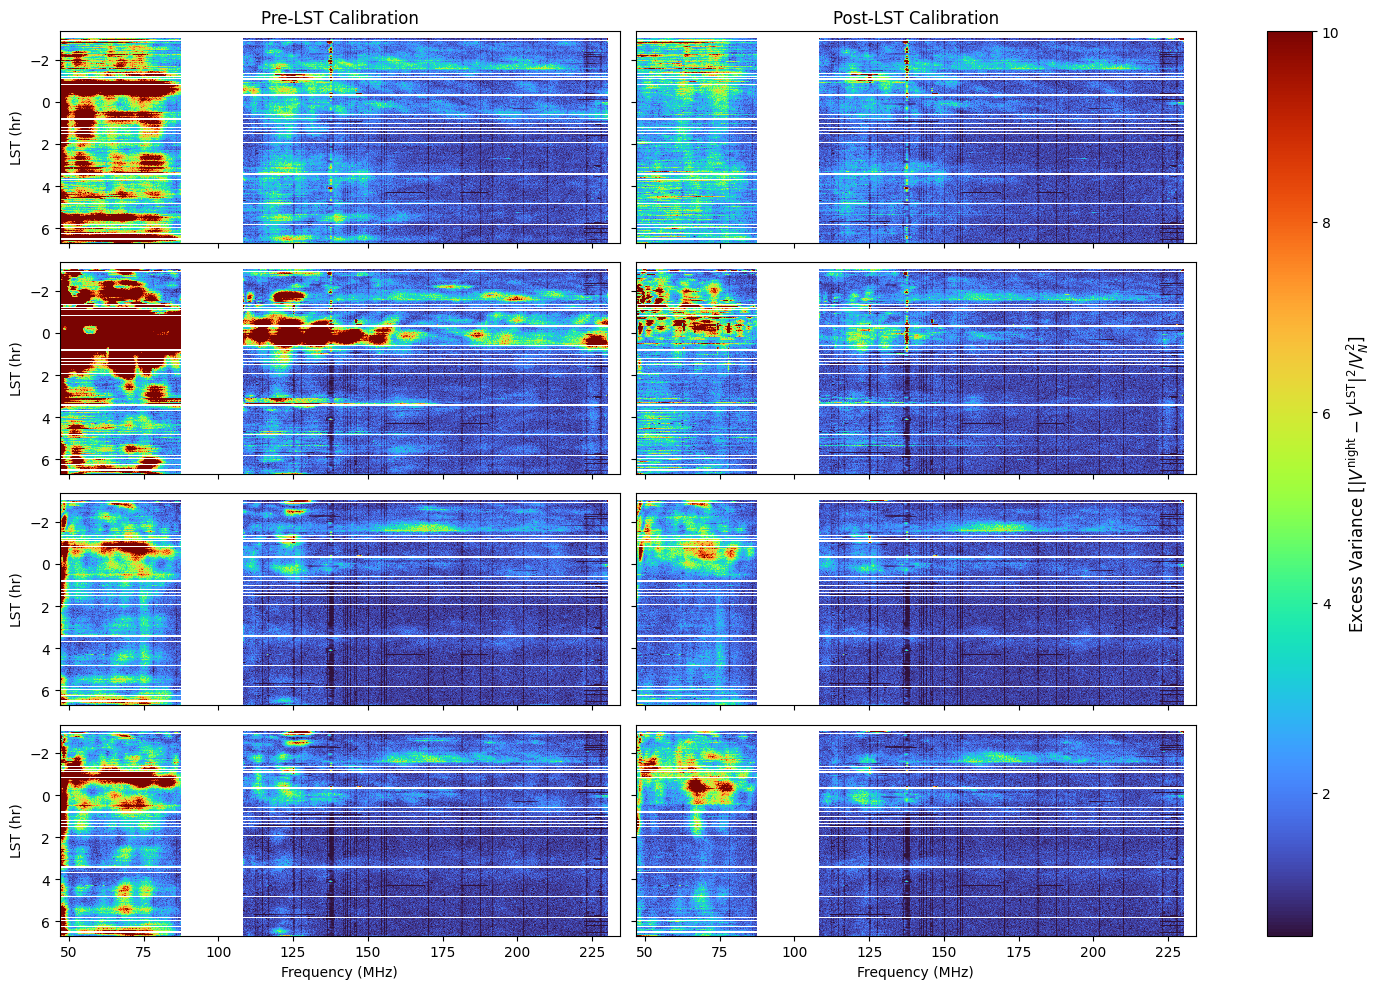

In [37]:
if RUN_CALIBRATION:
    all_calibration_parameters = {
        "amplitude_Jee": smoothed_amplitude['ee'],
        "amplitude_Jnn": smoothed_amplitude['nn'],
        "tip_tilt_Jee": smoothed_tip_tilt['ee'],
        "tip_tilt_Jnn": smoothed_tip_tilt['nn'],
        "cross_pol": cross_pol_smoothed,
    }
    
    
    fig, axs = plt.subplots(4, 2, figsize=(15, 10), sharey=True, sharex=True)
    
    for pi, pol in enumerate(['ee', 'nn']):
        excess_var = 0
        excess_var_cal = 0
        count = 0
        weights = 0
        for key in data_for_cal:
            if pol in key:
                noise_var = np.abs(auto_model[(0, 0, pol)]) ** 2 / wgts[key] / 10 / 122e3
                zsquare = np.abs(data_for_cal[key] - model[key]) ** 2 / noise_var
                excess_var += zsquare * (wgts[key])# * (~where_inpainted[pol]).astype(float))
                gain = expand_degenerate_gains_single_baseline(key, all_calibration_parameters, transformed_antpos, use_cross_pol=True)
                data_cal = data_for_cal[key] / gain
                zsquare = np.abs(data_cal - model[key]) ** 2 / noise_var
                excess_var_cal += zsquare * (wgts[key])# * (~where_inpainted[pol]).astype(float))
                weights += (wgts[key])# * (~where_inpainted[pol]).astype(float))
    
        im = axs[pi, 0].imshow(
            np.real(np.abs(excess_var) / weights), 
            aspect='auto', 
            interpolation='None', 
            cmap='turbo', 
            vmin=0.5, 
            vmax=10, 
            extent=extent
        )
        im = axs[pi, 1].imshow(
            np.real(np.abs(excess_var_cal) / weights), 
            aspect='auto', 
            interpolation='None', 
            cmap='turbo', 
            vmin=0.5, 
            vmax=10, 
            extent=extent
        )
    
    for pi, pol in enumerate(['en', 'ne']):
        excess_var = 0
        excess_var_cal = 0
        count = 0
        weights = 0
        for key in cross_pol_data:
            if pol in key:
                noise_var = np.abs(auto_model[(0, 0, "ee")] * auto_model[(0, 0, "nn")]) / wgts[key] / 10 / 122e3
                zsquare = np.abs(cross_pol_data[key] - cross_pol_model[key]) ** 2 / noise_var
                excess_var += zsquare * (wgts[key])# * (~where_inpainted[pol]).astype(float))
                gain = expand_degenerate_gains_single_baseline(key, all_calibration_parameters, transformed_antpos, use_cross_pol=True)
                data_cal = cross_pol_data[key] / gain
                zsquare = np.abs(data_cal - cross_pol_model[key]) ** 2 / noise_var
                excess_var_cal += zsquare * (wgts[key])# * (~where_inpainted[pol]).astype(float))
                weights += (wgts[key])# * (~where_inpainted[pol]).astype(float))
    
        im = axs[pi + 2, 0].imshow(
            np.real(np.abs(excess_var) / weights), 
            aspect='auto', 
            interpolation='None', 
            cmap='turbo', 
            vmin=0.5, 
            vmax=10, 
            extent=extent
        )
        im = axs[pi + 2, 1].imshow(
            np.real(np.abs(excess_var_cal) / weights), 
            aspect='auto', 
            interpolation='None', 
            cmap='turbo', 
            vmin=0.5, 
            vmax=10, 
            extent=extent
        )
    
    # Labeling
    for i in range(4):
        axs[i, 0].set_ylabel(r"LST (hr)")   
    
    axs[3, 0].set_xlabel(r"Frequency (MHz)")
    axs[3, 1].set_xlabel(r"Frequency (MHz)")
    axs[0, 0].set_title("Pre-LST Calibration")
    axs[0, 1].set_title("Post-LST Calibration")
    plt.tight_layout()
    cbar = plt.colorbar(im, ax=axs)
    cbar.set_label(r"Excess Variance $[|V^{\rm night} - V^{\rm LST}|^2 / V^2_N]$", fontsize=12)


In [ ]:
if RUN_CALIBRATION:
    indices = np.searchsorted(single_jd_times, times)
    
    # Expand out tip/tilt to full data size
    expanded_tip_tilt = {
        pol: np.zeros((single_jd_times.size,) + smoothed_tip_tilt[pol].shape[1:])
        for pol in smoothed_tip_tilt
    }
    expanded_amplitude = {
        pol: np.ones((single_jd_times.size,) + smoothed_amplitude[pol].shape[1:])
        for pol in smoothed_amplitude
    }
    for pol in expanded_tip_tilt:
        expanded_tip_tilt[pol][indices] = smoothed_tip_tilt[pol]
        expanded_amplitude[pol][indices] = np.where(
            np.isclose(smoothed_amplitude[pol], 0.0),
            1.0,
            smoothed_amplitude[pol]
        )
    
    # Expand out cross-polarized degeneracy to full data size
    expanded_cross_pol = np.zeros((single_jd_times.size,) + cross_pol_smoothed.shape[1:])
    expanded_cross_pol[indices] = cross_pol_smoothed

# 4. Save Smoothed Results

In [ ]:
if RUN_CALIBRATION:
    # Store calibration parameters
    all_calibration_parameters = {
        "amplitude_Jee": expanded_amplitude['ee'],
        "amplitude_Jnn": expanded_amplitude['nn'],
        "tip_tilt_Jee": expanded_tip_tilt['ee'],
        "tip_tilt_Jnn": expanded_tip_tilt['nn'],
        "cross_pol": expanded_cross_pol,
    }
    
    # Get the calibration filename
    cal_fname = os.path.join(OUTDIR, LSTCAL_FNAME_FORMAT.format(night=jd_here))

    # Make flag array
    sub_flag_array = np.array([all_flagged[pol] for pol in polarizations])
    
    flag_array = np.ones((len(polarizations), single_jd_times.size, freqs.size), dtype=sub_flag_array.dtype)
    flag_array[:, indices] = sub_flag_array

    # Write LST-cal solutions to disk
    lst_stack.calibration.write_single_baseline_lstcal_solutions(
        filename=cal_fname, 
        all_calibration_parameters=all_calibration_parameters, 
        flag_array=flag_array,
        transformed_antpos=transformed_antpos, 
        times=single_jd_times, 
        freqs=freqs, 
        pols=polarizations
    )